# PCA Algorithm & Clustering
Steps:
1. Read and understand the data
2. Outlier Testing
3. Visualize the correlation and Data Preparation
4. Use PCA and screeplot for choosing best number of PCs
5. Basis transformation - getting the data onto our PCs
6. Creating correlation matrix for the principal components - we expect little to no correlation
7. Clustering 
    - K-Means
    - Hierarchical
        - Single
        - Complete
8. Inferences

## 1. Read and Understand the data

In [1]:
# Importing required packages

import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# For Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# To Scale our data
from sklearn.preprocessing import StandardScaler

# Importing the PCA module
from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA

# To perform KMeans clustering 
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# To perform Hierarchical clustering
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

import warnings
warnings.filterwarnings('ignore')

In [2]:
country_df = pd.read_csv("Country-data.csv")

In [3]:
country_df.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [4]:
country_df.shape

(167, 10)

We have 10 dimensions which is very difficult to work with.
Lets see the data types of these 10 columns.

In [5]:
country_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
country       167 non-null object
child_mort    167 non-null float64
exports       167 non-null float64
health        167 non-null float64
imports       167 non-null float64
income        167 non-null int64
inflation     167 non-null float64
life_expec    167 non-null float64
total_fer     167 non-null float64
gdpp          167 non-null int64
dtypes: float64(7), int64(2), object(1)
memory usage: 13.2+ KB


No null values are observed.

In [6]:
country_df.describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,38.270060,41.108976,6.815689,46.890215,17144.688623,7.781832,70.555689,2.947964,12964.155689
std,40.328931,27.412010,2.746837,24.209589,19278.067698,10.570704,8.893172,1.513848,18328.704809
min,2.600000,0.109000,1.810000,0.065900,609.000000,-4.210000,32.100000,1.150000,231.000000
25%,8.250000,23.800000,4.920000,30.200000,3355.000000,1.810000,65.300000,1.795000,1330.000000
50%,19.300000,35.000000,6.320000,43.300000,9960.000000,5.390000,73.100000,2.410000,4660.000000
75%,62.100000,51.350000,8.600000,58.750000,22800.000000,10.750000,76.800000,3.880000,14050.000000
max,208.000000,200.000000,17.900000,174.000000,125000.000000,104.000000,82.800000,7.490000,105000.000000


Afghanistan and albania have similar imports percentange but their gdpp has a huge gap which doesn't give an accurate idea of which country is more developed than the other. Lets get absolute values for these values.

In [7]:
# Converting exports,imports and health spending percentages to absolute values
country_df['exports'] = country_df['exports']*country_df['gdpp']/100
country_df['imports'] = country_df['imports']*country_df['gdpp']/100
country_df['health'] = country_df['health']*country_df['gdpp']/100

In [8]:
country_df.describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,38.270060,7420.618847,1056.733204,6588.352108,17144.688623,7.781832,70.555689,2.947964,12964.155689
std,40.328931,17973.885795,1801.408906,14710.810418,19278.067698,10.570704,8.893172,1.513848,18328.704809
min,2.600000,1.076920,12.821200,0.651092,609.000000,-4.210000,32.100000,1.150000,231.000000
25%,8.250000,447.140000,78.535500,640.215000,3355.000000,1.810000,65.300000,1.795000,1330.000000
50%,19.300000,1777.440000,321.886000,2045.580000,9960.000000,5.390000,73.100000,2.410000,4660.000000
75%,62.100000,7278.000000,976.940000,7719.600000,22800.000000,10.750000,76.800000,3.880000,14050.000000
max,208.000000,183750.000000,8663.600000,149100.000000,125000.000000,104.000000,82.800000,7.490000,105000.000000


## 2. Outlier Analysis

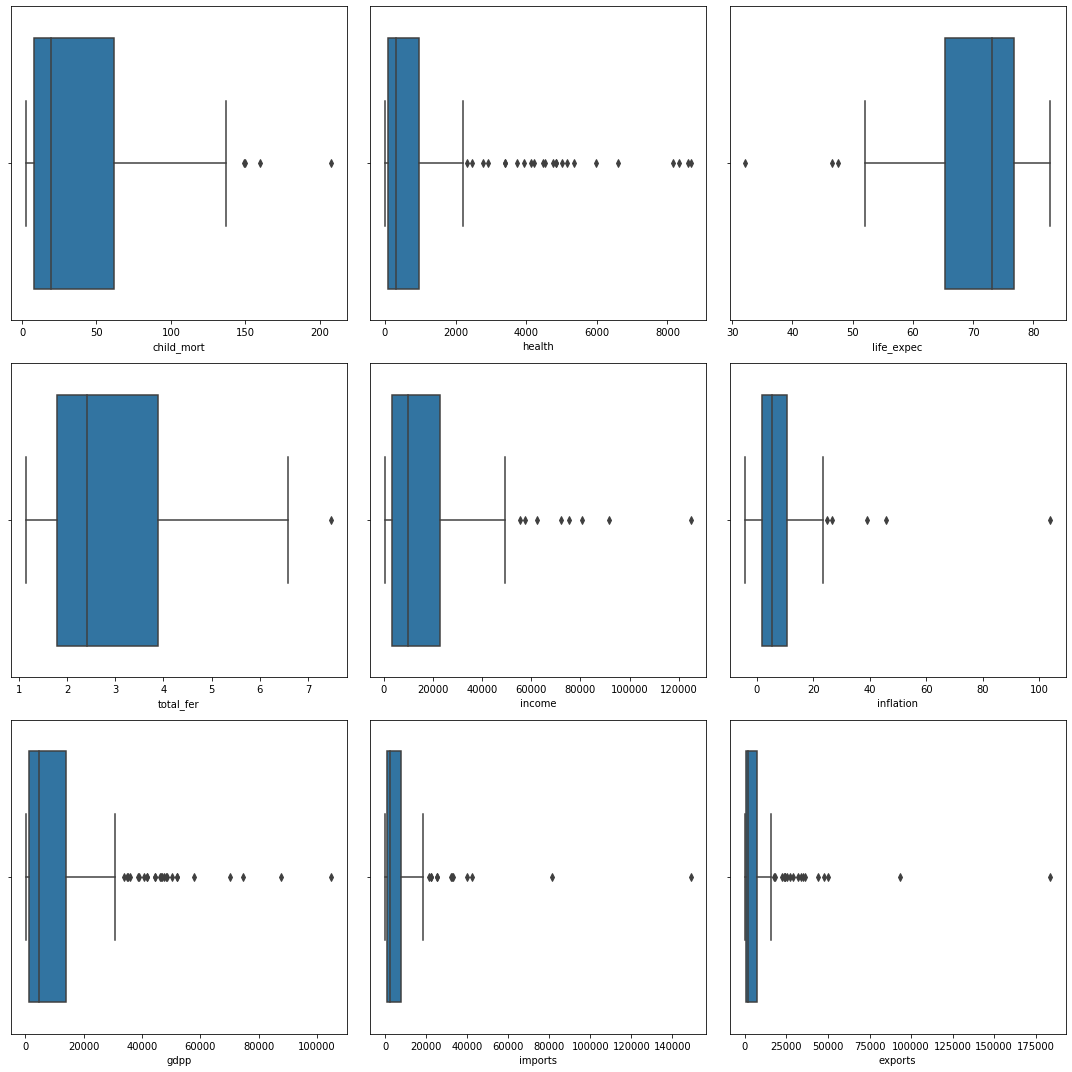

In [9]:
# We will see how values in each columns are distributed using boxplot
fig, axs = plt.subplots(3,3,figsize = (15,15))
plt1 = sns.boxplot(country_df['child_mort'], ax = axs[0,0])
plt2 = sns.boxplot(country_df['health'], ax = axs[0,1])
plt3 = sns.boxplot(country_df['life_expec'], ax = axs[0,2])
plt4 = sns.boxplot(country_df['total_fer'], ax = axs[1,0])
plt5 = sns.boxplot(country_df['income'], ax = axs[1,1])
plt6 = sns.boxplot(country_df['inflation'], ax = axs[1,2])
plt7 = sns.boxplot(country_df['gdpp'], ax = axs[2,0])
plt8 = sns.boxplot(country_df['imports'], ax = axs[2,1])
plt9 = sns.boxplot(country_df['exports'], ax = axs[2,2])


plt.tight_layout()

In [10]:
# We will cap the outliers to values accordingly for analysis.

percentiles = country_df['child_mort'].quantile([0.05,0.95]).values
country_df['child_mort'][country_df['child_mort'] <= percentiles[0]] = percentiles[0]
country_df['child_mort'][country_df['child_mort'] >= percentiles[1]] = percentiles[1]

percentiles = country_df['health'].quantile([0.05,0.95]).values
country_df['health'][country_df['health'] <= percentiles[0]] = percentiles[0]
country_df['health'][country_df['health'] >= percentiles[1]] = percentiles[1]

percentiles = country_df['life_expec'].quantile([0.05,0.95]).values
country_df['life_expec'][country_df['life_expec'] <= percentiles[0]] = percentiles[0]
country_df['life_expec'][country_df['life_expec'] >= percentiles[1]] = percentiles[1]

percentiles = country_df['total_fer'].quantile([0.05,0.95]).values
country_df['total_fer'][country_df['total_fer'] <= percentiles[0]] = percentiles[0]
country_df['total_fer'][country_df['total_fer'] >= percentiles[1]] = percentiles[1]

percentiles = country_df['income'].quantile([0.05,0.95]).values
country_df['income'][country_df['income'] <= percentiles[0]] = percentiles[0]
country_df['income'][country_df['income'] >= percentiles[1]] = percentiles[1]

percentiles = country_df['inflation'].quantile([0.05,0.95]).values
country_df['inflation'][country_df['inflation'] <= percentiles[0]] = percentiles[0]
country_df['inflation'][country_df['inflation'] >= percentiles[1]] = percentiles[1]

percentiles = country_df['gdpp'].quantile([0.05,0.95]).values
country_df['gdpp'][country_df['gdpp'] <= percentiles[0]] = percentiles[0]
country_df['gdpp'][country_df['gdpp'] >= percentiles[1]] = percentiles[1]

percentiles = country_df['imports'].quantile([0.05,0.95]).values
country_df['imports'][country_df['imports'] <= percentiles[0]] = percentiles[0]
country_df['imports'][country_df['imports'] >= percentiles[1]] = percentiles[1]

percentiles = country_df['exports'].quantile([0.05,0.95]).values
country_df['exports'][country_df['exports'] <= percentiles[0]] = percentiles[0]
country_df['exports'][country_df['exports'] >= percentiles[1]] = percentiles[1]

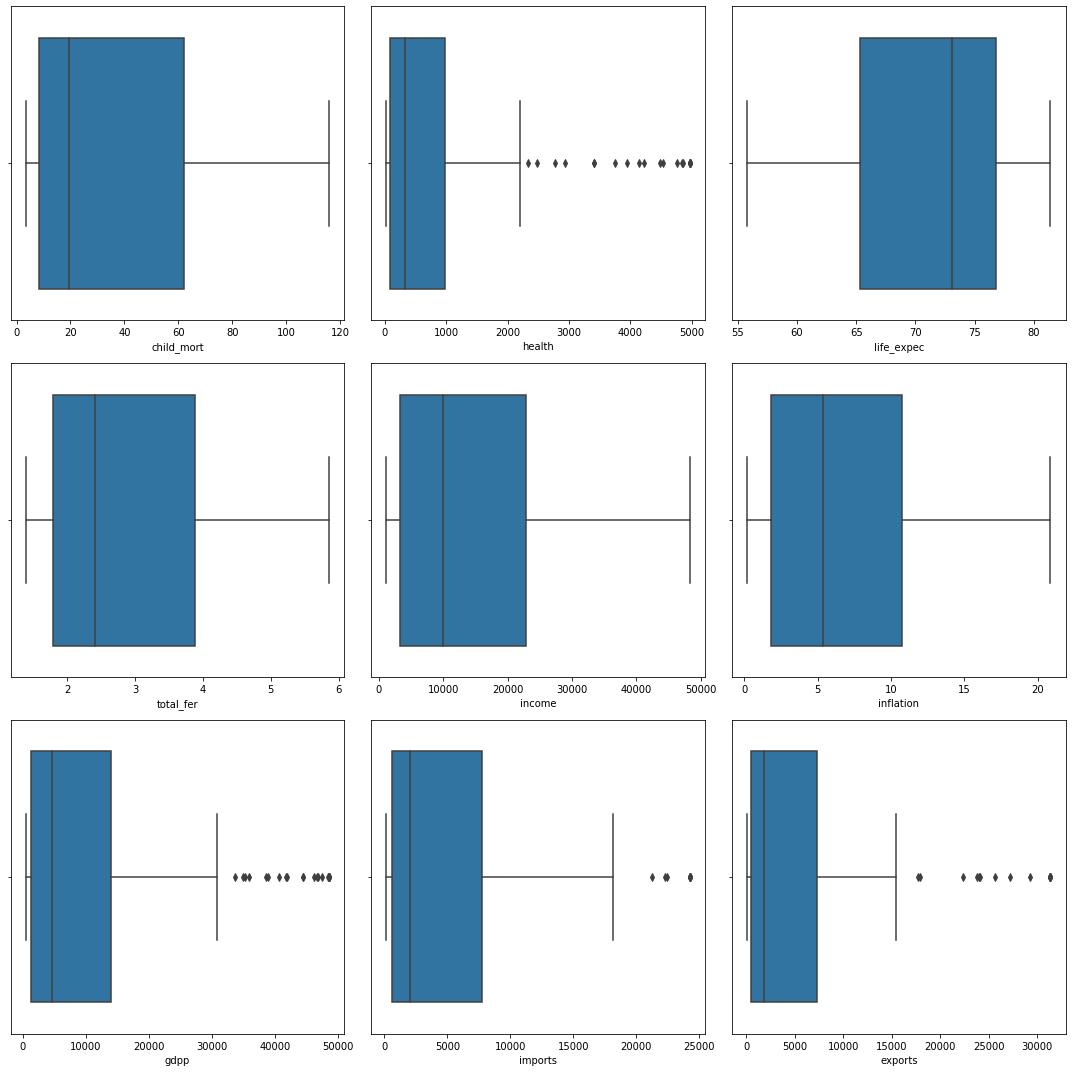

In [11]:
# We will see how values in each columns are distributed after handling the outliers using boxplot
fig, axs = plt.subplots(3,3,figsize = (15,15))
plt1 = sns.boxplot(country_df['child_mort'], ax = axs[0,0])
plt2 = sns.boxplot(country_df['health'], ax = axs[0,1])
plt3 = sns.boxplot(country_df['life_expec'], ax = axs[0,2])
plt4 = sns.boxplot(country_df['total_fer'], ax = axs[1,0])
plt5 = sns.boxplot(country_df['income'], ax = axs[1,1])
plt6 = sns.boxplot(country_df['inflation'], ax = axs[1,2])
plt7 = sns.boxplot(country_df['gdpp'], ax = axs[2,0])
plt8 = sns.boxplot(country_df['imports'], ax = axs[2,1])
plt9 = sns.boxplot(country_df['exports'], ax = axs[2,2])


plt.tight_layout()

Some of the outliers are handled here.

# 3. Visualize the correlation and Data Preparation:

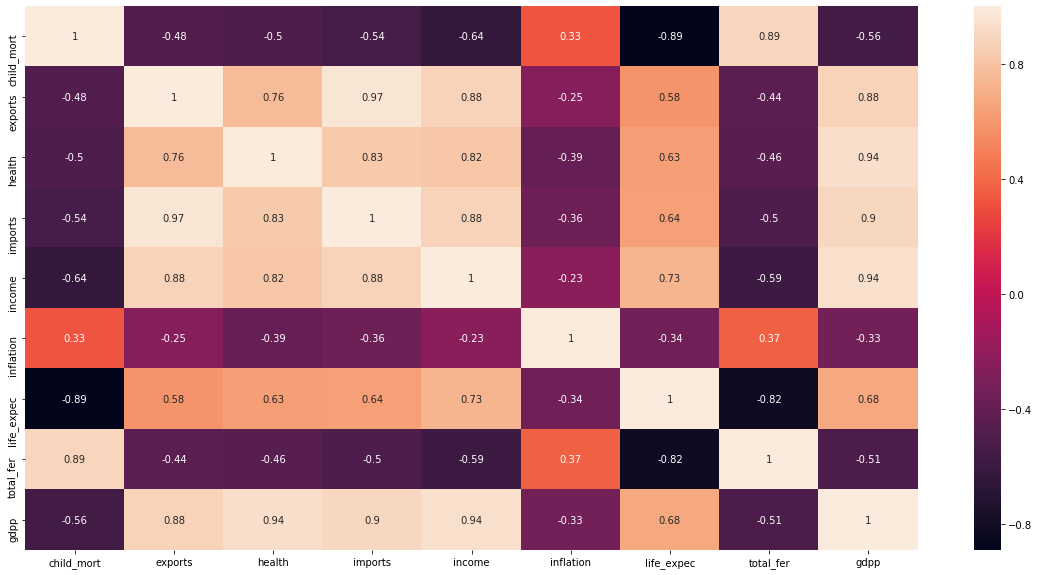

In [13]:
# Correlation - Heatmap
corre = country_df.corr()
plt.figure(figsize =(20,10))
ax = sns.heatmap(corre, annot = True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

A lot of highly correlated variables exist, hence the usage of PCA is justified.

### Data Preparation

In [13]:
# The final matrix would only contain the data columns. Hence let's drop the country column
X = country_df.copy()
X = X.drop(["country"], axis =1)
X

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,90.2,70.4688,41.9174,248.297,1610.0,9.44,56.20,5.820,553.0
1,16.6,1145.2000,267.8950,1987.740,9930.0,4.49,76.30,1.650,4090.0
2,27.3,1712.6400,185.9820,1400.440,12900.0,16.10,76.50,2.890,4460.0
3,116.0,2199.1900,100.6050,1514.370,5900.0,20.87,60.10,5.861,3530.0
4,10.3,5551.0000,735.6600,7185.800,19100.0,1.44,76.80,2.130,12200.0
...,...,...,...,...,...,...,...,...,...
162,29.2,1384.0200,155.9250,1565.190,2950.0,2.62,63.00,3.500,2970.0
163,17.1,3847.5000,662.8500,2376.000,16500.0,20.87,75.40,2.470,13500.0
164,23.3,943.2000,89.6040,1050.620,4490.0,12.10,73.10,1.950,1310.0
165,56.3,393.0000,67.8580,450.640,4480.0,20.87,67.50,4.670,1310.0


In [14]:
y = X.pop("gdpp")
y

0        553.0
1       4090.0
2       4460.0
3       3530.0
4      12200.0
        ...   
162     2970.0
163    13500.0
164     1310.0
165     1310.0
166     1460.0
Name: gdpp, Length: 167, dtype: float64

In [15]:
X.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer
0,90.2,70.4688,41.9174,248.297,1610.0,9.44,56.2,5.820
1,16.6,1145.2000,267.8950,1987.740,9930.0,4.49,76.3,1.650
2,27.3,1712.6400,185.9820,1400.440,12900.0,16.10,76.5,2.890
3,116.0,2199.1900,100.6050,1514.370,5900.0,20.87,60.1,5.861
4,10.3,5551.0000,735.6600,7185.800,19100.0,1.44,76.8,2.130


In [16]:
# Rescaling using Standardization method
# instantiate
scaler = StandardScaler()
# fit_transform
x_scl = scaler.fit_transform(X)
x_scl

array([[ 1.47958789, -0.66803864, -0.62977844, ...,  0.38766706,
        -1.82530988,  2.02071786],
       [-0.56002364, -0.54238923, -0.47380714, ..., -0.40400443,
         0.68245351, -0.88733091],
       [-0.26350403, -0.47604845, -0.53034406, ...,  1.45282506,
         0.70740638, -0.02258739],
       ...,
       [-0.37435248, -0.56600553, -0.59686482, ...,  0.81309053,
         0.2832076 , -0.67811877],
       [ 0.54014725, -0.63033074, -0.61187406, ...,  2.2157085 ,
        -0.41547275,  1.21873798],
       [ 1.28283189, -0.61312123, -0.59935647, ...,  1.11696443,
        -1.8777109 ,  1.72782086]])

## 4. Use PCA and screeplot for choosing best number of PCs

In [17]:
# Using the PCA module
pca = PCA(random_state=42)
pca.fit(x_scl)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=42,
    svd_solver='auto', tol=0.0, whiten=False)

In [18]:
# List of PCA components
# the same as the number of variables
pca.components_

array([[-0.35332201,  0.36905857,  0.36573904,  0.38967201,  0.39708397,
        -0.19363446,  0.37951745, -0.33785579],
       [ 0.45751377,  0.40840089,  0.28861052,  0.3456592 ,  0.22507472,
         0.18319949, -0.30871268,  0.49151739],
       [-0.17878695,  0.06607758, -0.13747222, -0.04433839,  0.16864298,
         0.9376255 ,  0.15486666, -0.106013  ],
       [ 0.02932754, -0.46913468,  0.76703904, -0.29184387,  0.0469907 ,
         0.11348116,  0.2276506 ,  0.19651953],
       [ 0.1288689 , -0.08753394,  0.28400801, -0.01931682,  0.05428485,
         0.09406042, -0.65624408, -0.6724927 ],
       [ 0.16190707, -0.14092313, -0.25890558, -0.36848197,  0.85087452,
        -0.15932112, -0.03135165,  0.0276064 ],
       [-0.76653162, -0.04869216,  0.04741893, -0.00766463,  0.1124139 ,
        -0.03079817, -0.50317291,  0.37547659],
       [ 0.05126415, -0.66532583, -0.16046876,  0.71086275,  0.14644429,
         0.04177298,  0.00568509,  0.02035266]])

In [19]:
# Let's check the variance ratios
pca.explained_variance_ratio_

array([0.66491472, 0.15304753, 0.10695257, 0.03211732, 0.01827586,
       0.01252299, 0.00999854, 0.00217047])

<BarContainer object of 8 artists>

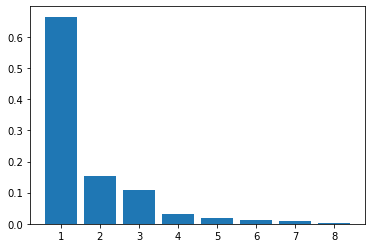

In [20]:
# Plotting explained variance ratio
plt.bar(range(1,len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_)

In [21]:
# Cumulative variance
var_cumu = np.cumsum(pca.explained_variance_ratio_)
var_cumu

array([0.66491472, 0.81796225, 0.92491482, 0.95703214, 0.975308  ,
       0.98783099, 0.99782953, 1.        ])

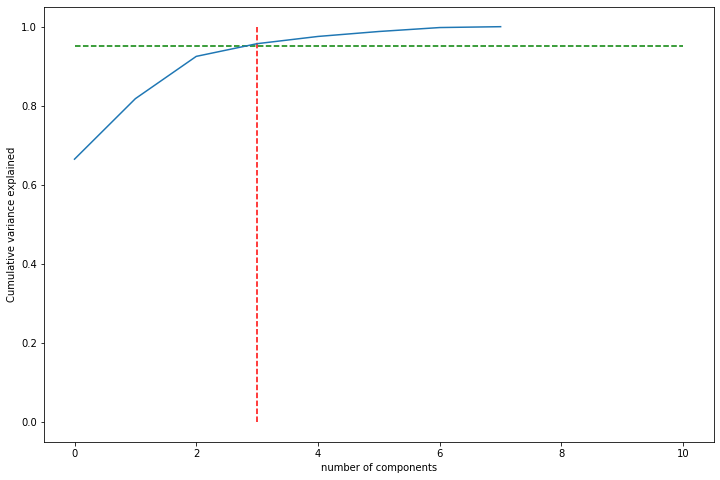

In [22]:
# Making the screeplot - plotting the cumulative variance against the number of components
fig = plt.figure(figsize=[12,8])
plt.vlines(x=3, ymax=1, ymin=0, colors="r", linestyles="--")
plt.hlines(y=0.95, xmax=10, xmin=0, colors="g", linestyles="--")
plt.plot(var_cumu)
plt.xlabel('number of components')
plt.ylabel("Cumulative variance explained")
plt.show()

Clearly over 95% of the data is properly explained by the first 3 principal components. Let's use them only for our clustering process

In [23]:
# Building a PCA model based on 3 Components using IncrementalPCA module

pca_final = IncrementalPCA(n_components=3)
pca_final

IncrementalPCA(batch_size=None, copy=True, n_components=3, whiten=False)

## 5. Basis transformation - getting the data onto our PCs

In [24]:
df_train_pca = pca_final.fit_transform(x_scl)
df_train_pca.shape

(167, 3)

In [25]:
# Take the transpose of the PC matrix so that we can create the new matrix
pc = np.transpose(df_train_pca)
pc

array([[-3.11729986e+00,  1.20140789e-01, -5.76964921e-01,
        -3.25254356e+00,  1.04552909e+00, -1.64929018e-01,
        -3.17929673e-01,  3.35187489e+00,  4.86617983e+00,
        -5.69335009e-01,  1.92468670e+00,  2.07496179e+00,
        -1.13588204e+00,  1.22225449e+00,  4.07511741e-02,
         5.02120490e+00, -2.56312448e-01, -2.67310375e+00,
        -7.21973122e-01, -1.15003921e+00,  4.83379851e-01,
        -1.26719527e+00,  1.06917718e-01,  2.45164429e+00,
         5.76723474e-01, -3.22624280e+00, -3.19684903e+00,
        -1.25851677e+00, -2.78897318e+00,  3.82444106e+00,
        -4.17118847e-01, -3.03547771e+00, -3.24330255e+00,
         8.64805516e-01, -8.68308173e-02,  6.08157245e-02,
        -2.20999791e+00, -3.68588811e+00, -2.53096267e+00,
         6.09659660e-01, -2.98667270e+00,  1.19090038e+00,
         3.12669295e+00,  2.41850889e+00,  5.00016919e+00,
        -3.44448950e-01, -2.83831722e-01, -9.53413702e-01,
        -2.34382190e-01, -1.05788292e+00, -2.30942914e+0

In [26]:
# Create the newer matrix according to the given principal components
rownames = list(country_df['country'])
pcs_df = pd.DataFrame({'country':rownames,'PC1':pc[0],'PC2':pc[1],'PC3':pc[2]})
pcs_df.head()

,country,PC1,PC2,PC3
0,Afghanistan,-3.117300,1.380466,-0.484530
1,Albania,0.120141,-1.588214,-0.096000
2,Algeria,-0.576965,-0.668296,1.552029
3,Angola,-3.252544,2.151635,1.222942
4,Antigua and Barbuda,1.045529,-0.900599,-0.487049


In [27]:
pcs_df.shape

(167, 4)

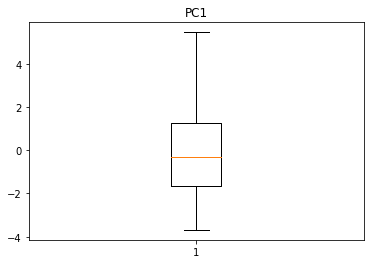

In [28]:
# Let's do the outlier analysis before proceeding to clustering
# We can reassign the outliers to the clusters later
plt.boxplot(pcs_df.PC1)
plt.title("PC1")
Q1 = pcs_df.PC1.quantile(0.05)
Q3 = pcs_df.PC1.quantile(0.95)
IQR = Q3 - Q1
pcs_df = pcs_df[(pcs_df.PC1 >= Q1) & (pcs_df.PC1 <= Q3)]

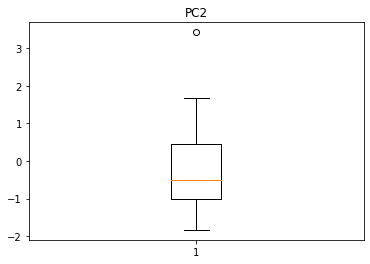

In [29]:
plt.boxplot(pcs_df.PC2)
plt.title("PC2")
Q1 = pcs_df.PC2.quantile(0.05)
Q3 = pcs_df.PC2.quantile(0.95)
IQR = Q3 - Q1
pcs_df = pcs_df[(pcs_df.PC2 >= Q1) & (pcs_df.PC2 <= Q3)]

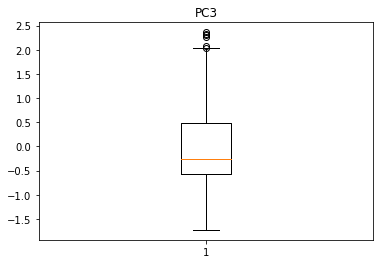

In [30]:
plt.boxplot(pcs_df.PC3)
plt.title("PC3")
Q1 = pcs_df.PC3.quantile(0.05)
Q3 = pcs_df.PC3.quantile(0.95)
IQR = Q3 - Q1
pcs_df2 = pcs_df[(pcs_df.PC3 >= Q1 ) & (pcs_df.PC3 <= Q3)]

In [31]:
# Outlier analysis is now done.Check the shape of the data again.
pcs_df.shape

(133, 4)

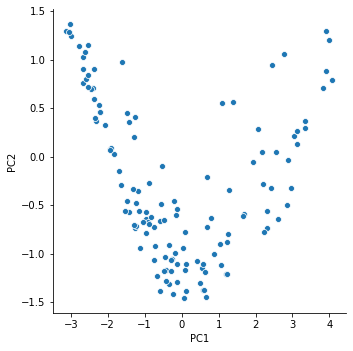

In [32]:
# Check the spread of the dataset
sns.pairplot(data=pcs_df, x_vars=["PC1"], y_vars=["PC2"], size=5)

## Step 6: Creating correlation matrix for the principal components - we expect little to no correlation:

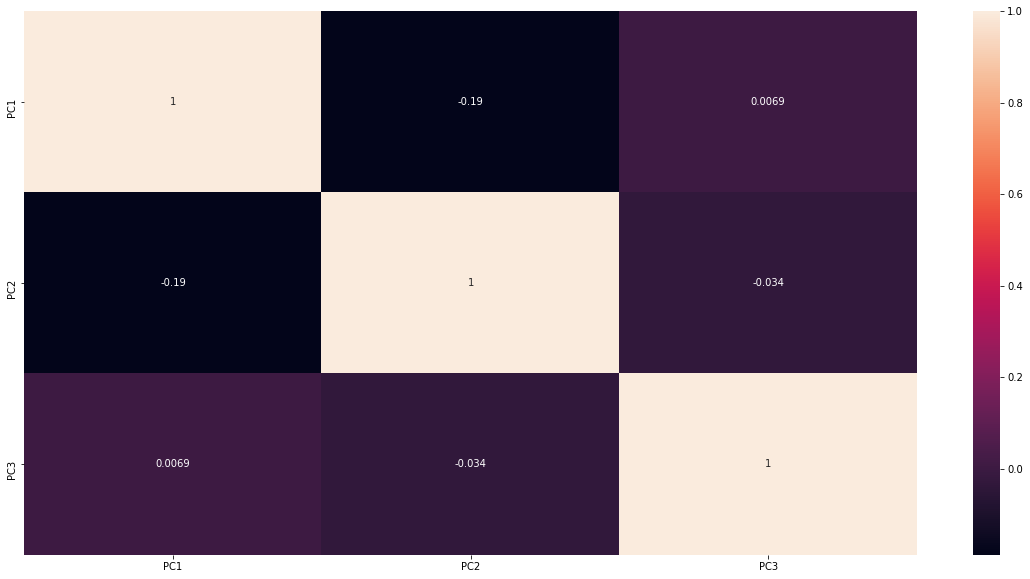

In [33]:
# Correlation Heatmap
corre = pcs_df.corr()
plt.figure(figsize =(20,10))
ax = sns.heatmap(corre, annot = True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

In [34]:
pcs_df

,country,PC1,PC2,PC3
2,Algeria,-0.576965,-0.668296,1.552029
4,Antigua and Barbuda,1.045529,-0.900599,-0.487049
5,Argentina,-0.164929,-0.597675,2.361220
7,Australia,3.351875,0.298231,-0.495268
9,Azerbaijan,-0.569335,-0.493641,1.114611
...,...,...,...,...
162,Vanuatu,-1.241921,-0.477135,-0.894166
163,Venezuela,-0.211221,-0.455722,2.334501
164,Vietnam,-0.658335,-1.230558,0.887187
165,Yemen,-2.223255,0.532177,1.728920


In [35]:
pcs_components = pcs_df.copy()
pcs_components.set_index("country", inplace = True)

In [36]:
pcs_components

,PC1,PC2,PC3
country,,,
Algeria,-0.576965,-0.668296,1.552029
Antigua and Barbuda,1.045529,-0.900599,-0.487049
Argentina,-0.164929,-0.597675,2.361220
Australia,3.351875,0.298231,-0.495268
Azerbaijan,-0.569335,-0.493641,1.114611
...,...,...,...
Vanuatu,-1.241921,-0.477135,-0.894166
Venezuela,-0.211221,-0.455722,2.334501
Vietnam,-0.658335,-1.230558,0.887187


## 7. Clustering:
- K-Means
- Hierarchical - Single and Complete


### K-Means:

In [37]:
# Instantiate: K-means with some arbitrary k --> we use a range for k to find out an optimum value
# The elbow-curve --> sum of squared distances (SSD):

ssd =[]
for num_clusters in range(2, 10):
    kmeans = KMeans(n_clusters = num_clusters, max_iter = 50)
    kmeans.fit(pcs_components)
    
    ssd.append(kmeans.inertia_)

ssd

[342.08359814757864,
 209.7003742345804,
 160.52361031079676,
 131.99403776644158,
 103.01182642922099,
 85.24494586172577,
 71.18446260473439,
 61.29391255329659]

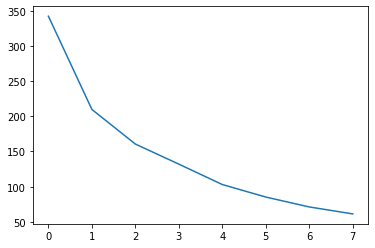

In [38]:
# plot the SSDs for each n_clusters
plt.plot(ssd)

- Till the elbow, i.e. cluster number 4, the rate of drop is significant
- After the increase in number of clusters, the rate of drop is not significant = ssd in decreased.
- As the number of clusters increase => ssd is decreased
- This is because, centroid is adjusted such that the data points are even more closer to the centroids.

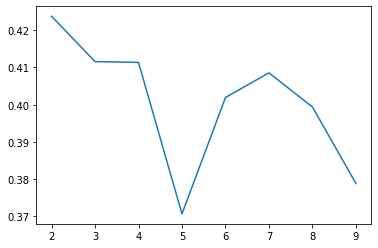

In [39]:
# silhouette score
sse_ = []
for k in range(2, 10):
    # initialiase k-means:
    kmeans = KMeans(n_clusters=k).fit(pcs_components)
    # silhouette score:
    sse = sse_.append([k, silhouette_score(pcs_components, kmeans.labels_)])

plt.plot(pd.DataFrame(sse_)[0], pd.DataFrame(sse_)[1]);

In [40]:
# K-means with k=4 clusters
model_clus5 = KMeans(n_clusters = 4, max_iter=50, random_state=42)
model_clus5.fit(pcs_components)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=50,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

In [41]:
Km_pcs_df = pcs_components
Km_pcs_df = Km_pcs_df.reset_index()
Km_pcs_df.index = pd.RangeIndex(len(Km_pcs_df.index))
data_km = pd.concat([Km_pcs_df, pd.Series(model_clus5.labels_)], axis=1)
data_km.columns = ['country','PC1', 'PC2','PC3','ClusterID']
data_km.head()

,country,PC1,PC2,PC3,ClusterID
0,Algeria,-0.576965,-0.668296,1.552029,3
1,Antigua and Barbuda,1.045529,-0.900599,-0.487049,0
2,Argentina,-0.164929,-0.597675,2.361220,3
3,Australia,3.351875,0.298231,-0.495268,1
4,Azerbaijan,-0.569335,-0.493641,1.114611,3


In [42]:
data_km['ClusterID'].value_counts()

0    52
2    35
1    27
3    19
Name: ClusterID, dtype: int64

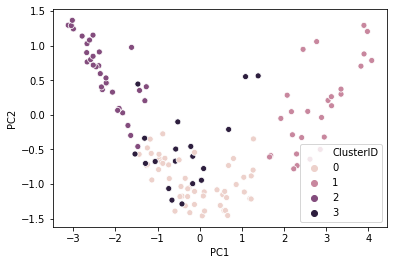

In [43]:
# Each cluster has a good number of countries associated with it (at least 5% of the dataset under consideration)
# Let's do some further visualizations. We'll be visualising the clusters on the original principal components

sns.scatterplot(x='PC1',y='PC2', hue='ClusterID', legend='full',data=data_km)

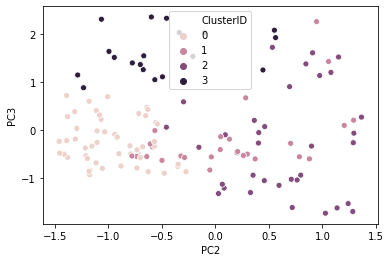

In [44]:
sns.scatterplot(x='PC2',y='PC3',hue='ClusterID',data=data_km)

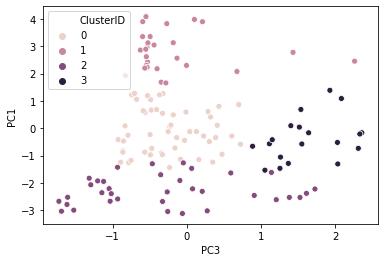

In [45]:
sns.scatterplot(x='PC3',y='PC1',hue='ClusterID',data=data_km)

One thing we noticed is some even though some distinct clusters are being formed, some are not so good.
Now let's create the cluster means with respect to the various variables mentioned in the question and plot and see how they are related

In [46]:
# Merging the original data set 'country_df' with K-means data set with principal components

km_merged_df = pd.merge(country_df,data_km,on='country')
km_clust_df1 = km_merged_df[['country','child_mort','exports','imports','health','income','inflation','life_expec','total_fer','gdpp','ClusterID']]

# Grouping and taking mean of the data to select appropriate features affecting the growth of the countries in the clusters.
km_grouped_df = km_clust_df1.groupby('ClusterID').mean()
km_grouped_df

,child_mort,exports,imports,health,income,inflation,life_expec,total_fer,gdpp
ClusterID,,,,,,,,,
0,22.894231,2578.655862,2968.575423,407.859878,10831.730769,4.543458,72.900000,2.414038,6028.115385
1,5.581481,13365.129630,12013.431852,2778.744889,34265.555556,2.644296,79.248148,1.744444,31944.814815
2,76.565714,615.649634,698.952371,111.039579,3489.200000,8.799000,61.487429,4.480343,1718.760000
3,22.326316,3150.609411,2307.245684,347.986895,16691.578947,16.530526,71.836842,2.397895,7181.684211


In [47]:
# Child mortality , income, GDP per capita, and Health spending are good predictors for the development of a country.
# Make a new dataframe using these 4 components:
Km_df = km_clust_df1[['ClusterID','country','income','child_mort','health','gdpp']]
Km_df.groupby('ClusterID').mean()

,income,child_mort,health,gdpp
ClusterID,,,,
0,10831.730769,22.894231,407.859878,6028.115385
1,34265.555556,5.581481,2778.744889,31944.814815
2,3489.200000,76.565714,111.039579,1718.760000
3,16691.578947,22.326316,347.986895,7181.684211


Countries in ClusterID = 2 are in the dire need of attention as this cluster has:
- low income, 
- high child mortality,
- less concern with health as indicated by lower spending in Health sector, and
- lowest average GDP that indicates that countries in this cluster are growing at a lower rate as compared to other clusters.

In [48]:
# Lets see which countries are included in cluster 2

country_in_need_km = Km_df[Km_df.ClusterID == 2].country.values
country_in_need_km

array(['Benin', 'Botswana', 'Cameroon', 'Central African Republic',
       'Comoros', 'Congo, Rep.', 'Eritrea', 'Gabon', 'Gambia', 'Ghana',
       'Guinea-Bissau', 'Haiti', 'India', 'Kenya', 'Kiribati', 'Lao',
       'Lesotho', 'Liberia', 'Madagascar', 'Malawi', 'Mauritania',
       'Namibia', 'Pakistan', 'Rwanda', 'Senegal', 'Solomon Islands',
       'South Africa', 'Sudan', 'Tajikistan', 'Tanzania', 'Timor-Leste',
       'Togo', 'Uganda', 'Yemen', 'Zambia'], dtype=object)

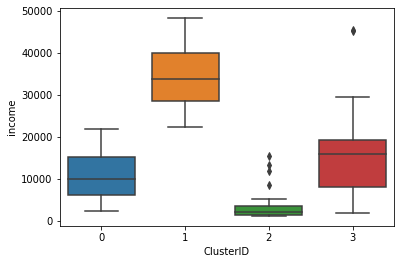

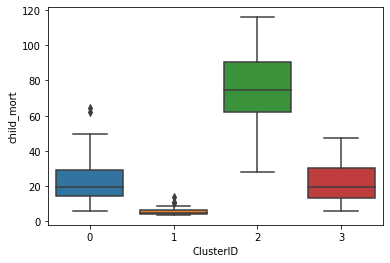

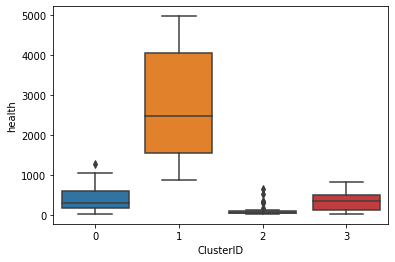

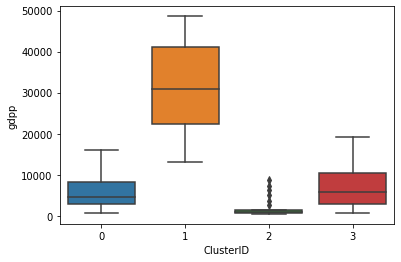

In [49]:
# Perform a bit of outlier analysis once again to understand how the dataset works here.
# PLOT
for i in Km_df.columns[2:]:
    sns.boxplot(x='ClusterID', y= i , data = Km_df)
    plt.show()

### Hierarchical Clustering:


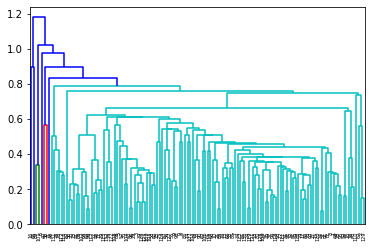

In [50]:
# Single Linkage method

mergings = linkage(pcs_components, method = "single", metric='euclidean')
dendrogram(mergings)
plt.show()

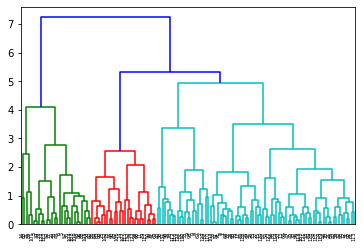

In [51]:
# Complete Linkage method

mergings = linkage(pcs_components, method = "complete", metric='euclidean')
dendrogram(mergings)
plt.show()

Now we are seeing some good clusters here.

Looking at the dendrogram it is observed that cutting it at n = 4 is most optimum.

In [52]:
pcs_components = pcs_components.reset_index()
pcs_components

,country,PC1,PC2,PC3
0,Algeria,-0.576965,-0.668296,1.552029
1,Antigua and Barbuda,1.045529,-0.900599,-0.487049
2,Argentina,-0.164929,-0.597675,2.361220
3,Australia,3.351875,0.298231,-0.495268
4,Azerbaijan,-0.569335,-0.493641,1.114611
...,...,...,...,...
128,Vanuatu,-1.241921,-0.477135,-0.894166
129,Venezuela,-0.211221,-0.455722,2.334501
130,Vietnam,-0.658335,-1.230558,0.887187
131,Yemen,-2.223255,0.532177,1.728920


In [53]:
# Cutting the tree at optimum number of clusters i.e. n_clusters = 4:

clusterCut = pd.Series(cut_tree(mergings, n_clusters = 4).reshape(-1,))
hier_clust = pd.concat([pcs_components, clusterCut], axis=1)
hier_clust.columns = ['country','PC1', 'PC2','PC3','ClusterID']

In [54]:
hier_clust

,country,PC1,PC2,PC3,ClusterID
0,Algeria,-0.576965,-0.668296,1.552029,0
1,Antigua and Barbuda,1.045529,-0.900599,-0.487049,1
2,Argentina,-0.164929,-0.597675,2.361220,0
3,Australia,3.351875,0.298231,-0.495268,2
4,Azerbaijan,-0.569335,-0.493641,1.114611,0
...,...,...,...,...,...
128,Vanuatu,-1.241921,-0.477135,-0.894166,1
129,Venezuela,-0.211221,-0.455722,2.334501,0
130,Vietnam,-0.658335,-1.230558,0.887187,0
131,Yemen,-2.223255,0.532177,1.728920,0


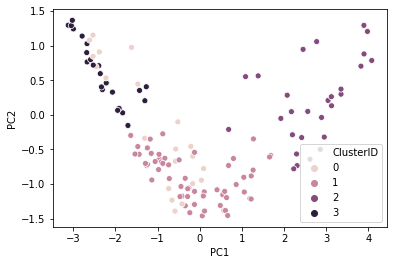

In [55]:
# Let's do some further visualizations. We'll be visualising the clusters on the original principal components

sns.scatterplot(x='PC1',y='PC2',hue='ClusterID',legend='full',data=hier_clust)

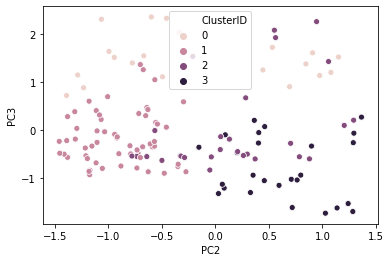

In [56]:
sns.scatterplot(x='PC2',y='PC3',hue='ClusterID',legend='full',data=hier_clust)

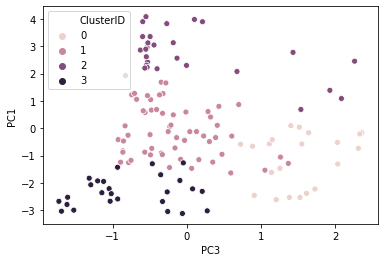

In [57]:
sns.scatterplot(x='PC3',y='PC1',hue='ClusterID',legend='full',data=hier_clust)

In [58]:
# Merging the original data set with hierarchically clustered data set:
clust_temp =pd.merge(country_df,hier_clust,on='country')
hier_merged_df=clust_temp[['country','child_mort','exports','imports','health','income','inflation','life_expec','total_fer','gdpp','ClusterID']]
hier_merged_df.head()

,country,child_mort,exports,imports,health,income,inflation,life_expec,total_fer,gdpp,ClusterID
0,Algeria,27.3,1712.64,1400.44,185.982,12900.0,16.10,76.5,2.89,4460.0,0
1,Antigua and Barbuda,10.3,5551.00,7185.80,735.660,19100.0,1.44,76.8,2.13,12200.0,1
2,Argentina,14.5,1946.70,1648.00,834.300,18700.0,20.87,75.8,2.37,10300.0,0
3,Australia,4.8,10276.20,10847.10,4530.870,41400.0,1.16,81.4,1.93,48610.0,2
4,Azerbaijan,39.2,3171.12,1208.88,343.392,16000.0,13.80,69.1,1.92,5840.0,0


In [59]:
hier_merged_df['ClusterID'].value_counts()

1    58
2    28
3    26
0    21
Name: ClusterID, dtype: int64

In [60]:
# Grouping and taking mean of the data to select appropriate features affecting the growth of the countries in the clusters.
hier_grouped_df = hier_merged_df.groupby('ClusterID').mean()
hier_grouped_df

,child_mort,exports,imports,health,income,inflation,life_expec,total_fer,gdpp
ClusterID,,,,,,,,,
0,36.957143,1818.356190,1456.729048,274.411524,10607.619048,17.400952,69.471429,3.092429,4890.000000
1,24.337931,2703.625269,3021.410655,399.135346,10784.827586,5.131203,72.662069,2.427414,5977.620690
2,6.578571,13191.735714,11561.630714,2679.198643,35731.071429,4.083071,79.160714,1.866429,31625.357143
3,79.742308,461.291354,671.953654,107.804149,3035.846154,5.859423,59.910000,4.500423,1449.176923


In [61]:
# Income, child_mort, GDP per capita, and Health expenses are good predictors for the development of a country.
# Make a new dataframe using these 4 components:
Hc_df = hier_merged_df[['ClusterID','country','income','child_mort','health','gdpp']]
Hc_df.groupby('ClusterID').mean()

,income,child_mort,health,gdpp
ClusterID,,,,
0,10607.619048,36.957143,274.411524,4890.000000
1,10784.827586,24.337931,399.135346,5977.620690
2,35731.071429,6.578571,2679.198643,31625.357143
3,3035.846154,79.742308,107.804149,1449.176923


Here, we can see that cluster 3 has:
- lowest income,
- high child mortality rate 
- lowest health expenses (which suggests compromising with health)
- and lowest GDP per capita.
Thus, countries in cluster 3 are in dire need of attention 

In [62]:
country_in_need_hc = Hc_df[Hc_df.ClusterID == 3].country.values
country_in_need_hc

array(['Benin', 'Botswana', 'Cameroon', 'Central African Republic',
       'Comoros', 'Eritrea', 'Gambia', 'Guinea-Bissau', 'Haiti', 'Kenya',
       'Kiribati', 'Lao', 'Lesotho', 'Liberia', 'Madagascar', 'Malawi',
       'Namibia', 'Pakistan', 'Rwanda', 'Senegal', 'Solomon Islands',
       'South Africa', 'Tanzania', 'Togo', 'Uganda', 'Zambia'],
      dtype=object)

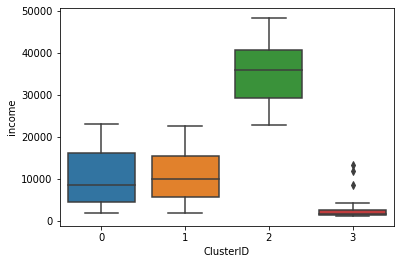

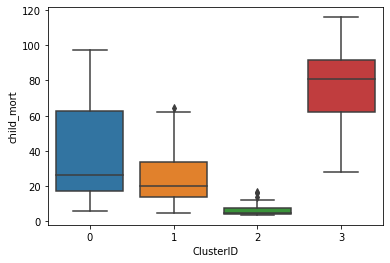

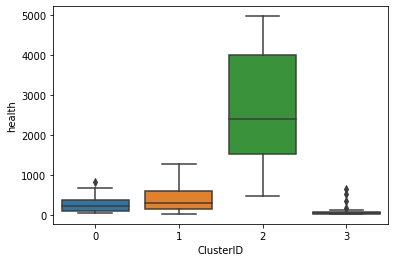

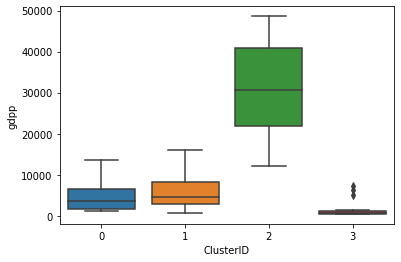

In [63]:
# perform a bit of outlier analysis once again to understand how the dataset works here.
# PLOT
for i in Hc_df.columns[2:]:
    sns.boxplot(x='ClusterID', y= i , data = Hc_df)
    plt.show()

# Inferences: 
In this solution it can be seen that the K-Means clustering and Hirarchichal Clustering produce somewhat similar results.

The clustering through hierarchical clustering is more accurate with respect to outliers and significance of the interpretations.

Thus, the countries in the direst need of attention are those obtained by Hierarchical Clustering.


Following is the **final list** of those countries:


**Benin, Botswana, Cameroon, Central African Republic, Comoros, Eritrea, Gambia, Guinea-Bissau, Haiti, Kenya, Kiribati, Lao, Lesotho, Liberia, Madagascar, Malawi, Namibia, Pakistan, Rwanda, Senegal, Solomon Islands, South Africa, Tanzania, Togo, Uganda, and Zambia.**

# End of the Assignment